Please notice that the paths in this file are broken, as it has been moved from project root into visualization folder

In [1]:
import torch
import xarray as xr
from torch import nn

from neuralnetwork.dataset import Precipitation, PrecipitationDataModule
from neuralnetwork.models import DenseNet

In [2]:
data_train = xr.open_dataset("./data/combined_train.nc")
data_test = xr.open_dataset("./data/combined_test.nc")

max_, min_ = data_train.max(dim="valid_time"), data_train.min(dim="valid_time")

In [3]:
from neuralnetwork.models import Linear

# (members, time, lat, lon)
linear_nogrid = Linear(False)
# FIXME average over members
linear_nogrid.fit(data_train["tp"].mean(dim = ["number"]), data_train["prec"])

Linear([0.21631817 0.01638969])

In [10]:
import pickle
from neuralnetwork import models

import sys
sys.modules["models"] = models

benchmark = (((data_test.tp - data_test.prec) ** 2).mean() ** .5).item()

model_error = {}
print(f"Benchmark: {benchmark:.4f} : {0:.2f}%")
for name in ["Debias", "Linear"]:
    with open(f"./checkpoints/{name}.pt", "rb") as f:
        model = pickle.load(f)
        error = model.predict(data_test.tp) - data_test.prec
        model_error[name] = error
        error = error.mean(dim="number")
        rse = ((error ** 2).mean() ** .5).item()
        print("{:9}: {:.4f} : {:.2f}%".format(name, rse, (benchmark - rse) / benchmark * 100))

error = linear_nogrid.predict(data_test.tp) - data_test.prec
rse = ((error.mean(dim="number") ** 2).mean() ** .5).item()
print("{:9}: {:.4f} : {:.2f}%".format("LinearF", rse, (benchmark - rse) / benchmark * 100))
model_error["nLinear"] = error

Benchmark: 0.0789 : 0.00%
Debias   : 0.0704 : 10.79%
Linear   : 0.0444 : 43.81%
LinearF  : 0.0448 : 43.28%


In [8]:
import torch
import numpy as np
from neuralnetwork.dataset import Precipitation
from neuralnetwork.models import DenseNetModule

test_data = Precipitation("./data/combined_test.nc", "tp", "prec")

# model = DenseNetModule.load_from_checkpoint(
#     "./checkpoints/DenseNetModule-v3.ckpt", grid=(8, 9)
# )  # Dense (128) 2.92

model = DenseNetModule.load_from_checkpoint(
    "./checkpoints/DenseNetModule-v6.ckpt", grid=(8, 9), hidden_size=64
) 

model.cpu()

rescale = lambda x, m: x * (max_.sel(number=m).prec.values - min_.sel(number=m).prec.values) + min_.sel(number=m).prec.values

with torch.no_grad():
    preds = [
        rescale(model(test_data.X[m, ...]).numpy(), m)
        for m in range(test_data.number)
    ]

error = np.mean(np.stack(preds), axis=0) - test_data.y.numpy()
rse = (error**2).mean() ** 0.5
# print("{:9}: {:.4f} : {:.2f}%".format("Dense (128)", rse, (benchmark - rse) / benchmark * 100))
print("{:9}: {:.4f} : {:.2f}%".format("Dense (64)", rse, (benchmark - rse) / benchmark * 100))
model_error["DenseNet"] = xr.DataArray(
    preds,
    coords={
        "number": range(51), 
        "valid_time": data_test.valid_time, 
        "latitude": data_test.latitude, 
        "longitude": data_test.longitude, 
    },
)

Dense (64): 0.0433 : 45.12%


c:\Users\felipe\.conda\envs\genv\Lib\site-packages\pytorch_lightning\utilities\migration\utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.4, which is newer than your current Lightning version: v2.0.2
  rank_zero_warn(


In [ ]:
# Benchmark 0.0789   0.00%
# Debias    0.0704   10.79%
# Linear    0.0444   43.81%
# LinearF   0.0448   43.28%
# Dense (128)   0.0433     45.13%
# Dense (64): 0.0433 : 45.12%

Text(0.5, 1.0, 'DenseNet with 128 hidden units')

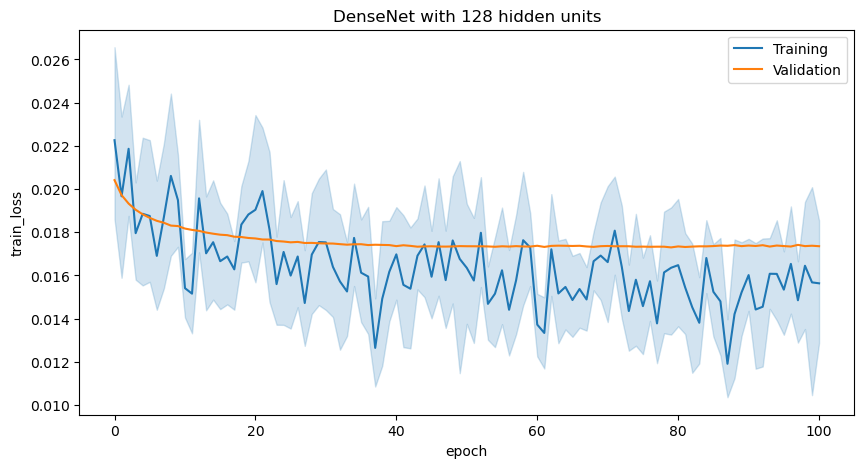

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

metrics = pd.read_csv(r"lightning_logs\DenseNetModule_1733\version_0\metrics.csv")
# metrics = pd.read_csv(r"lightning_logs\DenseNetModule_2000\version_0\metrics.csv")
metrics = metrics[metrics.epoch <= 100]

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=metrics, x="epoch", y="train_loss", ax=ax, label="Training")
sns.lineplot(data=metrics, x="epoch", y="val_loss", ax=ax, label="Validation")
plt.title("DenseNet with 128 hidden units")

In [12]:
vmin, vmax = 0.013475324508904065, 0.0571609487587921

for error in model_error.values():
    member = error.mean(dim=["number", "valid_time"])
    if member.min() < vmin:
        vmin = member.min().item()
    if member.max() > vmax:
        vmax = member.max().item()

vmin, vmax

(-0.02713115502380263, 0.0571609487587921)

Text(0.5, 1.0, 'Average Seasonal Forecast Error Post Processed by nGrid Linear')

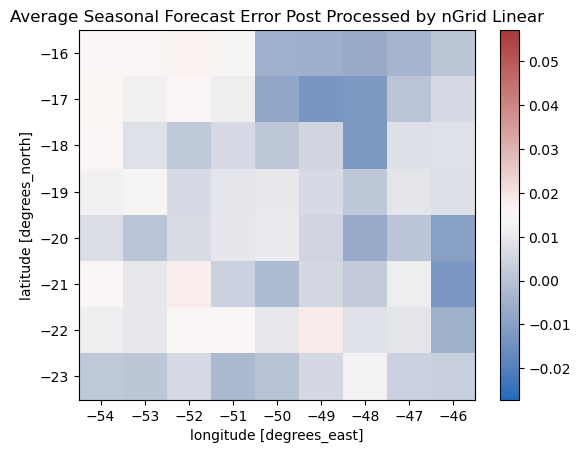

In [14]:
error = model_error["nLinear"]
error.mean(dim=["number", "valid_time"]).plot.pcolormesh(
    x="longitude", y="latitude", cmap="vlag", vmin = vmin, vmax = vmax
)
plt.title("Average Seasonal Forecast Error Post Processed by nGrid Linear")

c:\Users\felipe\.conda\envs\genv\Lib\site-packages\xarray\core\accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


Text(0.5, 1.0, 'Post-processed error distribution between $\\textbf{forecast}$ and $\\textbf{observation}$')

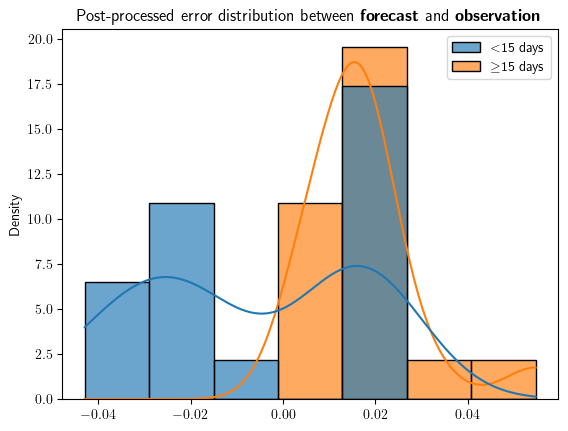

In [18]:
plt.rcParams['text.usetex'] = True

threshold = 15
error_dist = error.mean(dim=["latitude", "longitude", "number"])
sns.histplot(
    x=error_dist,
    stat="density",
    hue=np.where(error_dist["valid_time"].dt.day.values < threshold, rf"$\textless${threshold} days", f"$\ge${threshold} days"),
    multiple="layer",
    kde=True,
    alpha=0.66,
)
plt.title(rf"Post-processed error distribution between $\textbf{{forecast}}$ and $\textbf{{observation}}$")

Text(0.5, 1.0, 'Seasonal mean error')

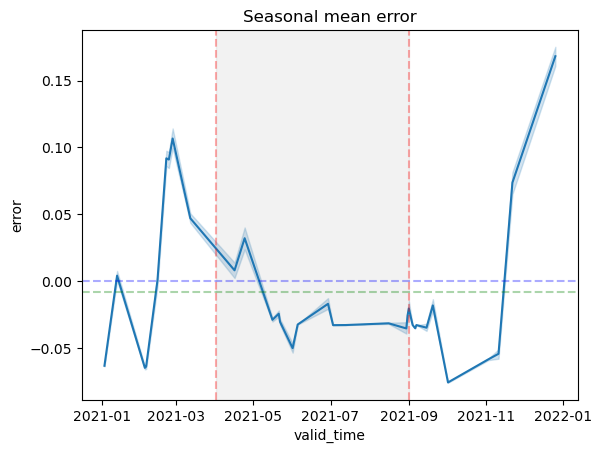

In [25]:
bias = error.mean()
time_mean = error.mean(dim = ["latitude", "longitude"]).to_dataframe(name = "error").reset_index()
sns.lineplot(x = "valid_time", y = "error", data = time_mean, color = sns.color_palette()[0])
plt.axvline(pd.to_datetime("2021-04-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvline(pd.to_datetime("2021-09-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvspan(pd.to_datetime("2021-04-01"), pd.to_datetime("2021-09-01"), color = "gray", alpha = .1)
plt.axhline(0.0, color = "blue", linestyle = "--", alpha = .33)
plt.axhline(bias, color = "green", linestyle = "--", alpha = .33)
plt.title("Seasonal mean error")

Text(0.5, 1.0, 'Average Seasonal Forecast Error Post Processed by Linear')

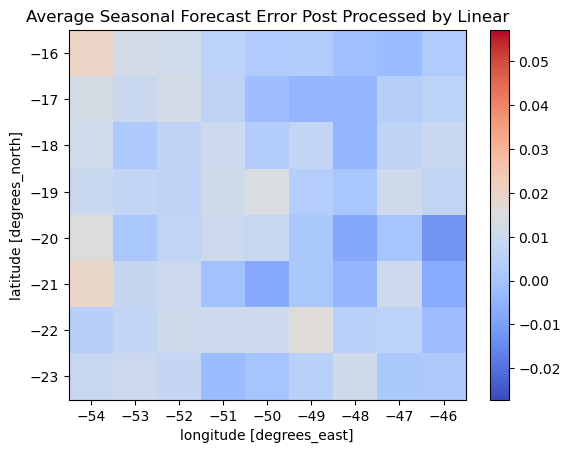

In [61]:
error = model_error["Linear"]
error.mean(dim=["number", "valid_time"]).plot.pcolormesh(
    x="longitude", y="latitude", cmap="vlag", vmin=vmin, vmax=vmax
)
plt.title("Average Seasonal Forecast Error Post Processed by Linear")


Text(0.5, 1.0, 'Seasonal mean error')

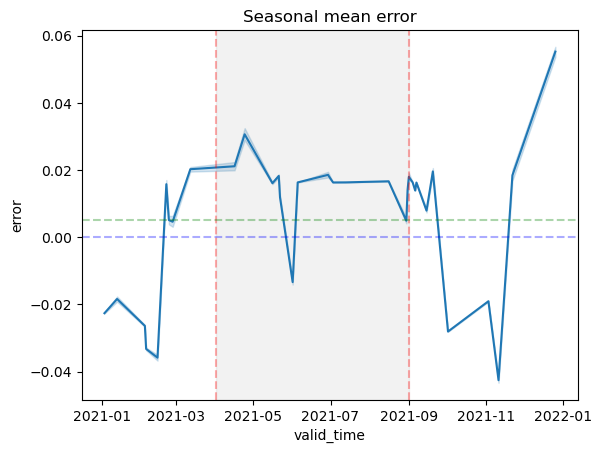

In [28]:
bias = error.mean()
time_mean = error.mean(dim = ["latitude", "longitude"]).to_dataframe(name = "error").reset_index()
sns.lineplot(x = "valid_time", y = "error", data = time_mean, color = sns.color_palette()[0])
plt.axvline(pd.to_datetime("2021-04-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvline(pd.to_datetime("2021-09-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvspan(pd.to_datetime("2021-04-01"), pd.to_datetime("2021-09-01"), color = "gray", alpha = .1)
plt.axhline(0.0, color = "blue", linestyle = "--", alpha = .33)
plt.axhline(bias, color = "green", linestyle = "--", alpha = .33)
plt.title("Seasonal mean error")

Text(0.5, 1.0, 'Average Seasonal Forecast Error Post Processed by DenseNet')

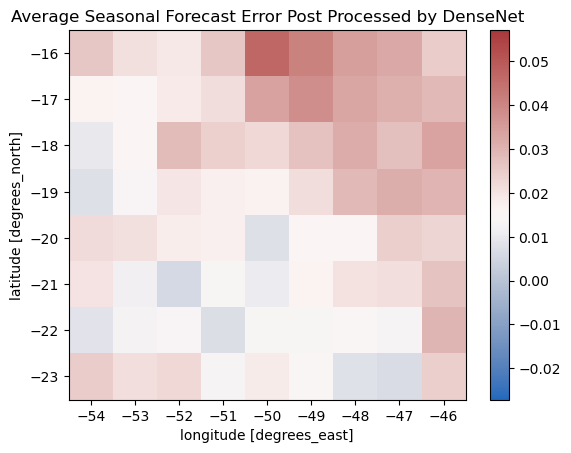

In [64]:
error = model_error["DenseNet"]
error.mean(dim=["number", "valid_time"]).plot.pcolormesh(
    x="longitude", y="latitude", cmap="vlag",
    vmin = vmin, vmax = vmax
)
plt.title("Average Seasonal Forecast Error Post Processed by DenseNet")

Text(0.5, 1.0, 'Seasonal mean error')

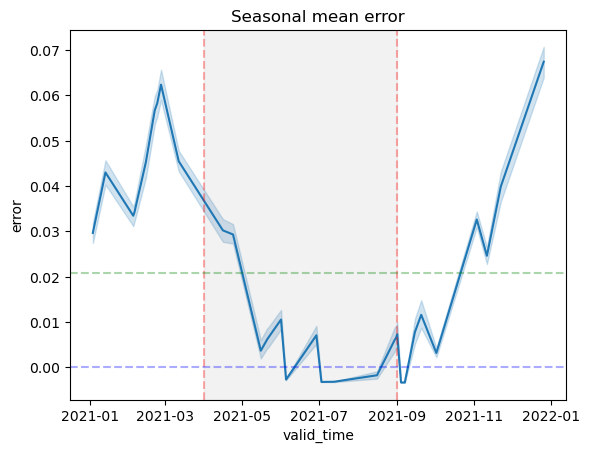

In [43]:
bias = error.mean()
time_mean = error.mean(dim = ["latitude", "longitude"]).to_dataframe(name = "error").reset_index()
sns.lineplot(x = "valid_time", y = "error", data = time_mean, color = sns.color_palette()[0])
plt.axvline(pd.to_datetime("2021-04-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvline(pd.to_datetime("2021-09-01"), color = "red", linestyle = "--", alpha = .33)
plt.axvspan(pd.to_datetime("2021-04-01"), pd.to_datetime("2021-09-01"), color = "gray", alpha = .1)
plt.axhline(0.0, color = "blue", linestyle = "--", alpha = .33)
plt.axhline(bias, color = "green", linestyle = "--", alpha = .33)
plt.title("Seasonal mean error")

In [9]:
files = "./2022/MERGE/*.grib2"
ds = xr.open_mfdataset(
    files,
    engine="cfgrib",
    concat_dim="time",
    combine="nested",
)

seasonal_path = r".\2022\adaptor.mars.external-1688672675.3837378-32186-14-b57bf29b-f6bf-4a0d-b40d-a1326c138f8d.grib"
merge_path = "./2022/fmerge_2022.nc"

# use `valid_time` as indexer and remove 2022-01-01
seasonal = xr.open_dataset(seasonal_path, engine="cfgrib", backend_kwargs=dict(time_dims=('valid_time',))).isel(valid_time = slice(None, -1))

interp_lat, interp_lon = seasonal.latitude, seasonal.longitude
merge = (ds.assign_coords(longitude=ds.longitude - 360.0) / 100).copy() # xr.open_dataset(merge_path) / 100 # FIXME shouldn't be 1_000 to transform `mm` into `m` ?
interp_merge = merge.interp(latitude=interp_lat, longitude=interp_lon, time = seasonal.valid_time)

ds = xr.merge([interp_merge.drop("prmsl"), seasonal])
# ds["day"] = ds.valid_time.dt.day

true_test = ds.compute()

In [26]:
true_test

<xarray.Dataset>
Dimensions:     (valid_time: 89, latitude: 8, longitude: 9, number: 51)
Coordinates:
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -16.0 -17.0 -18.0 -19.0 ... -21.0 -22.0 -23.0
  * longitude   (longitude) float64 -54.0 -53.0 -52.0 ... -48.0 -47.0 -46.0
    time        (valid_time) datetime64[ns] 2022-01-02 2022-01-03 ... 2022-03-31
  * valid_time  (valid_time) datetime64[ns] 2022-01-02 2022-01-03 ... 2022-03-31
  * number      (number) int32 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
Data variables:
    prec        (valid_time, latitude, longitude) float64 0.1241 ... 0.09031
    tp          (number, valid_time, latitude, longitude) float32 0.008179 .....
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-07-06T20:07 GRIB to CDM+CF via cfgrib-0.9.1...

In [35]:
# xr.apply_ufunc(linear_nogrid.predict, true_test.tp, input_core_dims=[["number"]])
 
preds = xr.DataArray(
    [
        linear_nogrid.predict(true_test.isel(number = m).tp) for m in true_test.number.values
    ],
    coords={
        "number": range(51), 
        "valid_time": true_test.valid_time, 
        "latitude": true_test.latitude, 
        "longitude": true_test.longitude, 
    },
    # method = "override"
)

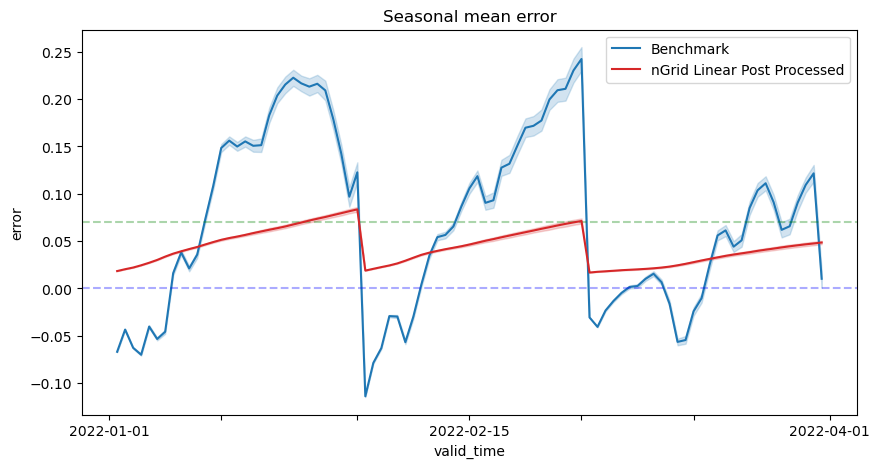

In [46]:
error = (ds.tp - ds.prec)
bias = error.mean()

fig, ax = plt.subplots(figsize = (10, 5))

time_mean = error.mean(dim = ["latitude", "longitude"]).to_dataframe(name = "error").reset_index()
sns.lineplot(ax = ax, x = "valid_time", y = "error", data = time_mean, color = sns.color_palette()[0], label = "Benchmark")
# plt.axvline(pd.to_datetime("2021-04-01"), color = "red", linestyle = "--", alpha = .33)
# plt.axvline(pd.to_datetime("2021-09-01"), color = "red", linestyle = "--", alpha = .33)
# plt.axvspan(pd.to_datetime("2021-04-01"), pd.to_datetime("2021-09-01"), color = "gray", alpha = .1)
ax.axhline(0.0, color = "blue", linestyle = "--", alpha = .33)
ax.axhline(bias, color = "green", linestyle = "--", alpha = .33)

ptime_mean = preds.mean(dim = ["latitude", "longitude"]).to_dataframe(name = "error").reset_index()
sns.lineplot(ax = ax, x = "valid_time", y = "error", data = ptime_mean, color = sns.color_palette()[3], label = "nGrid Linear Post Processed")

plt.title("Seasonal mean error")

def reduce_xticks(p, n: int):
    # FIXME reducing the number of xticks
    # from https://stackoverflow.com/a/38947307/14403987
    for i, label in enumerate(p.get_xticklabels()):
        label.set_visible(True if i % n == 0 else False)

reduce_xticks(ax, 3)

Text(0.5, 1.0, 'Post-processed error distribution between $\\textbf{forecast}$ and $\\textbf{observation}$')

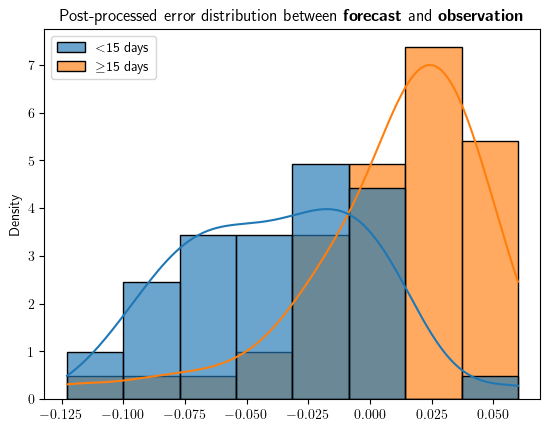

In [48]:
import numpy as np

plt.rcParams['text.usetex'] = True

threshold = 15

error = preds - ds.prec

error_dist = error.mean(dim=["latitude", "longitude", "number"])
sns.histplot(
    x=error_dist,
    stat="density",
    hue=np.where(error_dist["valid_time"].dt.day.values < threshold, rf"$\textless${threshold} days", f"$\ge${threshold} days"),
    multiple="layer",
    kde=True,
    alpha=0.66,
)
plt.title(rf"Post-processed error distribution between $\textbf{{forecast}}$ and $\textbf{{observation}}$")